In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from tpot import TPOTClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

import utils

# Read data

In [2]:
df = pd.read_parquet('data-input/flirt-wesad-acc-bvp-eda-temp-60-10.parquet')

In [3]:
# remove columns (see EDA)
columns_to_drop = ['eda_EDA_n_sign_changes',
 'temp_TEMP_peaks',
 'acc_y_entropy',
 'acc_l2_n_sign_changes',
 'acc_x_entropy',
 'acc_z_entropy',
 'temp_l2_n_sign_changes',
 'bvp_BVP_entropy',
 'temp_TEMP_n_sign_changes',
 'temp_l2_peaks',
 'eda_l2_n_sign_changes']

df = df.drop(columns=columns_to_drop)

In [4]:
# split into train and test
df_train, df_test = utils.create_train_test(df, 5, 'subject', 'label')

X_train, y_train, groups_train = utils.split_df(df_train, 'subject', 'label')
X_test, y_test, groups_test = utils.split_df(df_test, 'subject', 'label')

# remove correlated features from train
X_train, selected_features = utils.remove_correlated_features(X_train, 0.8)

# remove the same columns from test
X_test = X_test[selected_features]

In [5]:
X_train.shape

(2213, 72)

In [6]:
X_test.shape

(552, 72)

In [7]:
X_train.columns

Index(['bvp_BVP_mean', 'bvp_BVP_std', 'bvp_BVP_sum', 'bvp_BVP_skewness',
       'bvp_BVP_kurtosis', 'bvp_BVP_peaks', 'bvp_BVP_n_above_mean',
       'bvp_BVP_n_below_mean', 'bvp_BVP_n_sign_changes',
       'bvp_BVP_perm_entropy', 'bvp_BVP_svd_entropy', 'bvp_l2_min',
       'bvp_l2_n_above_mean', 'bvp_l2_n_below_mean', 'bvp_l2_n_sign_changes',
       'bvp_l2_perm_entropy', 'acc_x_mean', 'acc_x_std', 'acc_x_ptp',
       'acc_x_energy', 'acc_x_skewness', 'acc_x_kurtosis', 'acc_x_peaks',
       'acc_x_lineintegral', 'acc_x_n_above_mean', 'acc_x_n_below_mean',
       'acc_x_n_sign_changes', 'acc_y_mean', 'acc_y_std', 'acc_y_min',
       'acc_y_max', 'acc_y_energy', 'acc_y_skewness', 'acc_y_kurtosis',
       'acc_y_peaks', 'acc_y_n_above_mean', 'acc_y_n_sign_changes',
       'acc_y_svd_entropy', 'acc_z_mean', 'acc_z_std', 'acc_z_min',
       'acc_z_max', 'acc_z_energy', 'acc_z_skewness', 'acc_z_kurtosis',
       'acc_z_n_above_mean', 'acc_z_n_below_mean', 'acc_z_n_sign_changes',
       'acc_z

In [8]:
# Check train and test set sizes
print('Percentage train set:', len(y_train)/(len(y_train)+len(y_test)))
print('Percentage test set:', len(y_test)/(len(y_train)+len(y_test)))

print('\nClass distribution in train set: \n', y_train['label'].value_counts(normalize=True), '\n')

print('Class distribution in test set: \n', y_test['label'].value_counts(normalize=True), '\n')

Percentage train set: 0.8003616636528029
Percentage test set: 0.1996383363471971

Class distribution in train set: 
 0    0.6385
1    0.3615
Name: label, dtype: float64 

Class distribution in test set: 
 0    0.634058
1    0.365942
Name: label, dtype: float64 



# TPOT

In [9]:
tpot = TPOTClassifier(generations=5,
                      population_size=5,
                      scoring='f1',
                      cv=3,
                      n_jobs=-1,
                      verbosity=3,
                      random_state=0)

In [10]:
%%time
tpot.fit(X_train, y_train.values.ravel(), groups=groups_train.values.ravel())

32 operators have been imported by TPOT.


C:\Tools\anaconda3\envs\stress01\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8908177405779621	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.4, XGBClassifier__verbosity=0)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.8908177405779621	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.4, XGBClassifier__verbosity=0)
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).

Generation 3 - Current Pareto front scores:

-1	0.8908177405779621	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1,

TPOTClassifier(cv=3, generations=5, n_jobs=-1, population_size=5,
               random_state=0, scoring='f1', verbosity=3)

In [11]:
print(f"TPOT score (F1) on test data: {tpot.score(X_test, y_test.values.ravel()):.2f}")

TPOT score (F1) on test data: 0.88


C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [12]:
y_test_predict = tpot.predict(X_test)
y_test_predict_proba = tpot.predict_proba(X_test)[:,1]

C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [13]:
print('accuracy: '+str(accuracy_score(y_test, y_test_predict)))
print('precision: '+str(precision_score(y_test, y_test_predict)))
print('recall: '+str(recall_score(y_test, y_test_predict)))
print('f1_score: '+str(f1_score(y_test, y_test_predict)))
print('roc_auc: '+str(roc_auc_score(y_test, y_test_predict)))
print('Class distribution in test set: \n', y_test['label'].value_counts(normalize=True), '\n')
print('average_precision: '+str(average_precision_score(y_test, y_test_predict_proba)))

accuracy: 0.9112318840579711
precision: 0.8558139534883721
recall: 0.9108910891089109
f1_score: 0.882494004796163
roc_auc: 0.9111598302687411
Class distribution in test set: 
 0    0.634058
1    0.365942
Name: label, dtype: float64 

average_precision: 0.9570895587694306


In [14]:
confusion_matrix(y_test, y_test_predict)

array([[319,  31],
       [ 18, 184]], dtype=int64)

The baseline to beat is the percentage of positive cases: 0.36594202898550726


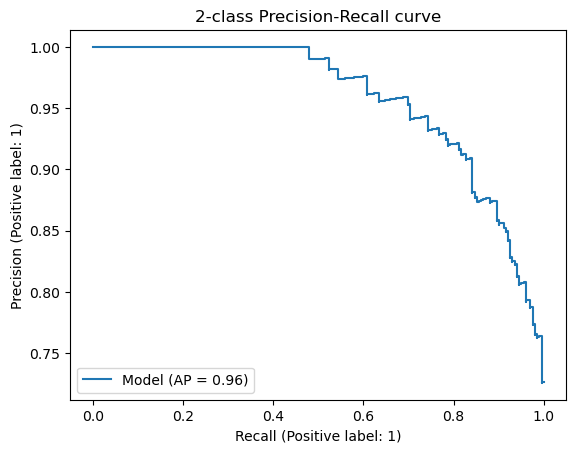

In [15]:
prd = PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_proba, name='Model')
_ = prd.ax_.set_title('2-class Precision-Recall curve')
print('The baseline to beat is the percentage of positive cases:', y_test['label'].value_counts(normalize=True)[1])

# Interpretation

I created a TPOT baseline model in this notebook.

The data used was created with ```FLIRT``` with a ```window_size``` of ```60``` and a step size of ```10```.

The data of each user is either in the train or in the test set. Internally, TPOT does a cross-validation with the training data, and again only uses the data of each user in either training or validation set.

Hyperparameters, i.e., aspects that could be changed in future iterations:
* Calculating the features with another library instead of FLIRT.
* Using different window_sizes and step sizes.
* Test if we can predict stress by only using a subset of the available sensors.

The results so far are very promising: TPOT returned a pipeline with a performance on the test set of F1=0.88.